In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import re

In [7]:
def read_hex_data(result, results_name, variable):
    
    hex_data = result[results_name][variable]["data"]["bytes"]
    byte_data = bytes.fromhex(" ".join([format(n, "02x") for n in hex_data]))
                                       
    dtype = result[results_name][variable]["dtype"]
    shape = result[results_name][variable]["shape"]
    
    return np.frombuffer(byte_data, dtype=dtype).reshape(shape)

def read_indexed_values(result, results_name, variable):
    
    data = result[results_name][variable]
    
    return data[0]

def get_wavenumbers(file_name):
    lines = list(open(file_name))
    
    break_points = []
    
    for enum, line in enumerate(lines):
        if "[" in line:
            break_points.append(enum)
            
    frequencies = [float(re.findall(r'-?\d+\.\d+', freq_line)[0]) for freq_line in lines[break_points[1]+1:break_points[2]-1]]
    
    return np.array(frequencies)
    

def get_mode(file_name, mode, n_atoms):
    norm_coord = []
    
    lines = list(open(file_name))
        
    for enum, line in enumerate(lines):
        if f"vibration {mode}\n" in line:
            for mode_line in range(enum+1, enum+1+n_atoms):
                norm_coord.append([float(x) for x in re.findall(r'-?\d+\.\d+', lines[mode_line])])
    
    return np.array(norm_coord)
                
def wavenumber_to_frequency(wavenumber):
    c = 2.99792458e10 # cm s-1
    
    frequency = wavenumber * c # cm-1 * cm s-1
    
    frequency_fs = frequency * 1e-15
    
    return frequency_fs

def read_symbols(file_name):
    symbols = []
    
    with open(file_name, 'r') as f:
        lines = list(f.readlines())
        
        for line in lines:
            symbol = re.findall(r'[A-Za-z]+', line)
            
            if len(symbol) != 0:
                symbols.append(symbol[0])
                
    return symbols
                

In [8]:
wavenumbers = get_wavenumbers("monomer_normal_modes.molden")

frequencies = wavenumber_to_frequency(wavenumbers)

(79, 231)


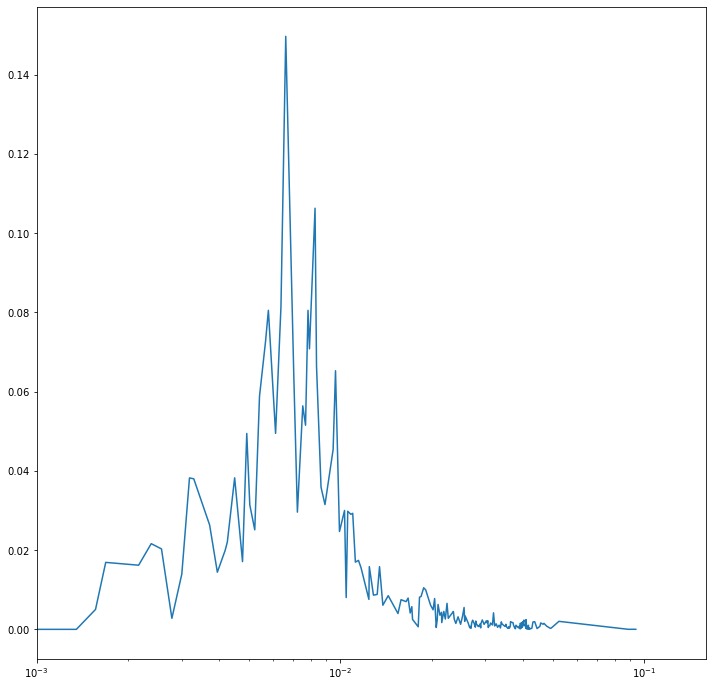

In [96]:
fig, ax = plt.subplots()

n_atoms = 79
n_modes = 3 * n_atoms - 6

Mg_index = 0

all_displacements = np.zeros((n_atoms, n_modes))

for i in range(n_modes):
    if frequencies[i] <= 0.00156316:
        continue
    
    mode_i = get_mode("monomer_normal_modes.molden", i+1, 79)
    
    all_displacements[:,i] = np.linalg.norm(mode_i, axis=1)
    
print(all_displacements.shape)
    
ax.plot(frequencies, all_displacements[Mg_index])

ax.set_xlim(1e-3, 0.16)

ax.set_xscale('log')

fig.set_size_inches(12,12)

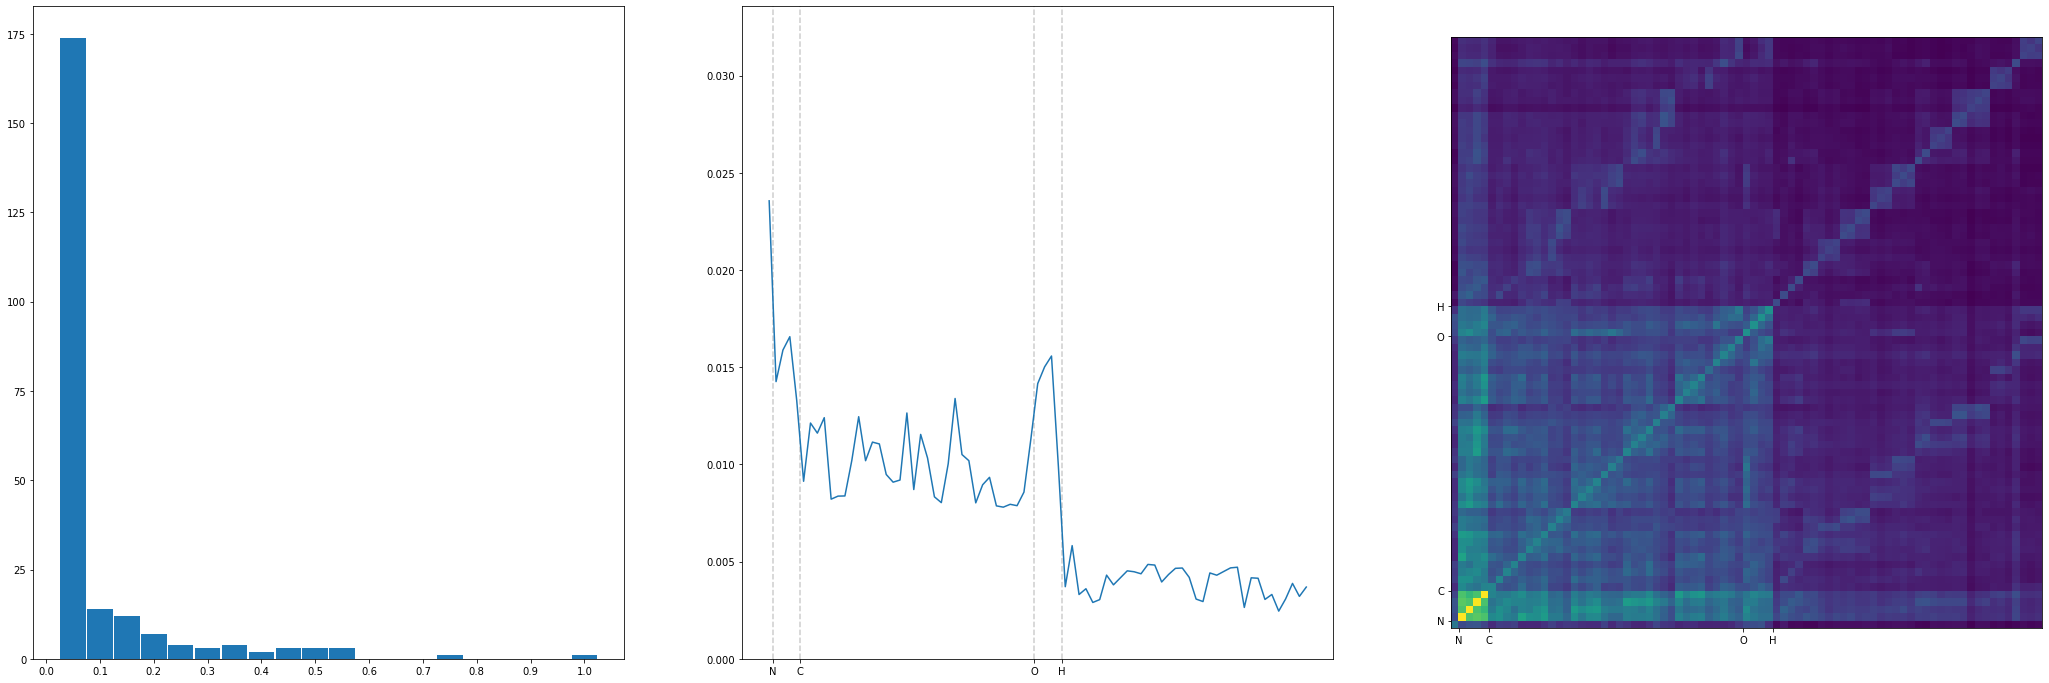

In [147]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1, 3)

symbols = read_symbols("monomer.xyz")

Mg_indices = np.array([enum for enum, x in enumerate(symbols) if x == "Mg"])
N_indices = np.array([enum for enum, x in enumerate(symbols) if x == "N"])
C_indices = np.array([enum for enum, x in enumerate(symbols) if x == "C"])
O_indices = np.array([enum for enum, x in enumerate(symbols) if x == "O"])
H_indices = np.array([enum for enum, x in enumerate(symbols) if x == "H"])

Mg_avg_disp= all_displacements[Mg_indices].max()
N_avg_disp = all_displacements[N_indices].max()
C_avg_disp = all_displacements[C_indices].max()
O_avg_disp = all_displacements[O_indices].max()
H_avg_disp = all_displacements[H_indices].max()

normalized_displacements = all_displacements

normalized_displacements[Mg_indices] /= Mg_avg_disp
normalized_displacements[N_indices] /= N_avg_disp
normalized_displacements[C_indices] /= C_avg_disp
normalized_displacements[O_indices] /= O_avg_disp
normalized_displacements[H_indices] /= H_avg_disp

grouped_symbols = np.concatenate((Mg_indices, N_indices, C_indices, O_indices, H_indices))

normalized_displacements = normalized_displacements[grouped_symbols]

#print(all_displacements[Mg_indices])

bins = np.linspace(0, 1, 21)
his = np.histogram(normalized_displacements[Mg_index], bins=bins)


ax[0].bar(his[1][1:], his[0], width=1/len(bins), align='center')
ax[0].set_xticks(bins[::2])

Mg_displacements = np.where(normalized_displacements[Mg_index] > 0.0)[0]

correlation = np.zeros((n_atoms, n_atoms))

for i in Mg_displacements:
    correlation += np.outer(normalized_displacements[:,i], normalized_displacements[:,i])
    
correlation /= len(Mg_displacements)

cax = ax[2].imshow(correlation, origin='lower', cmap=plt.get_cmap('viridis'))#, norm=LogNorm(vmin=0.0001, vmax=20))
    
#fig.colorbar(cax)

# number of each element --  Mg: 1, N: 4, C: 34, O: 4, H: 36
# cumulative -- 1, 5, 39, 43, 79

symbol_ticks = [0.5, 4.5, 38.5, 42.5]
symbol_labels= ["N","C","O","H"]

ax[2].set_xticks(symbol_ticks)
ax[2].set_xticklabels(symbol_labels)

ax[2].set_yticks(symbol_ticks)
ax[2].set_yticklabels(symbol_labels)

ax[1].plot(correlation[0])
ax[1].set_xticks(symbol_ticks)
ax[1].set_xticklabels(symbol_labels)

ax[1].vlines(symbol_ticks, color='black', linestyle='--', ymin=0, ymax=max(correlation[0])+0.01, alpha=0.2)
ax[1].set_ylim(0, max(correlation[0])+0.01)

fig.set_size_inches(36,12)